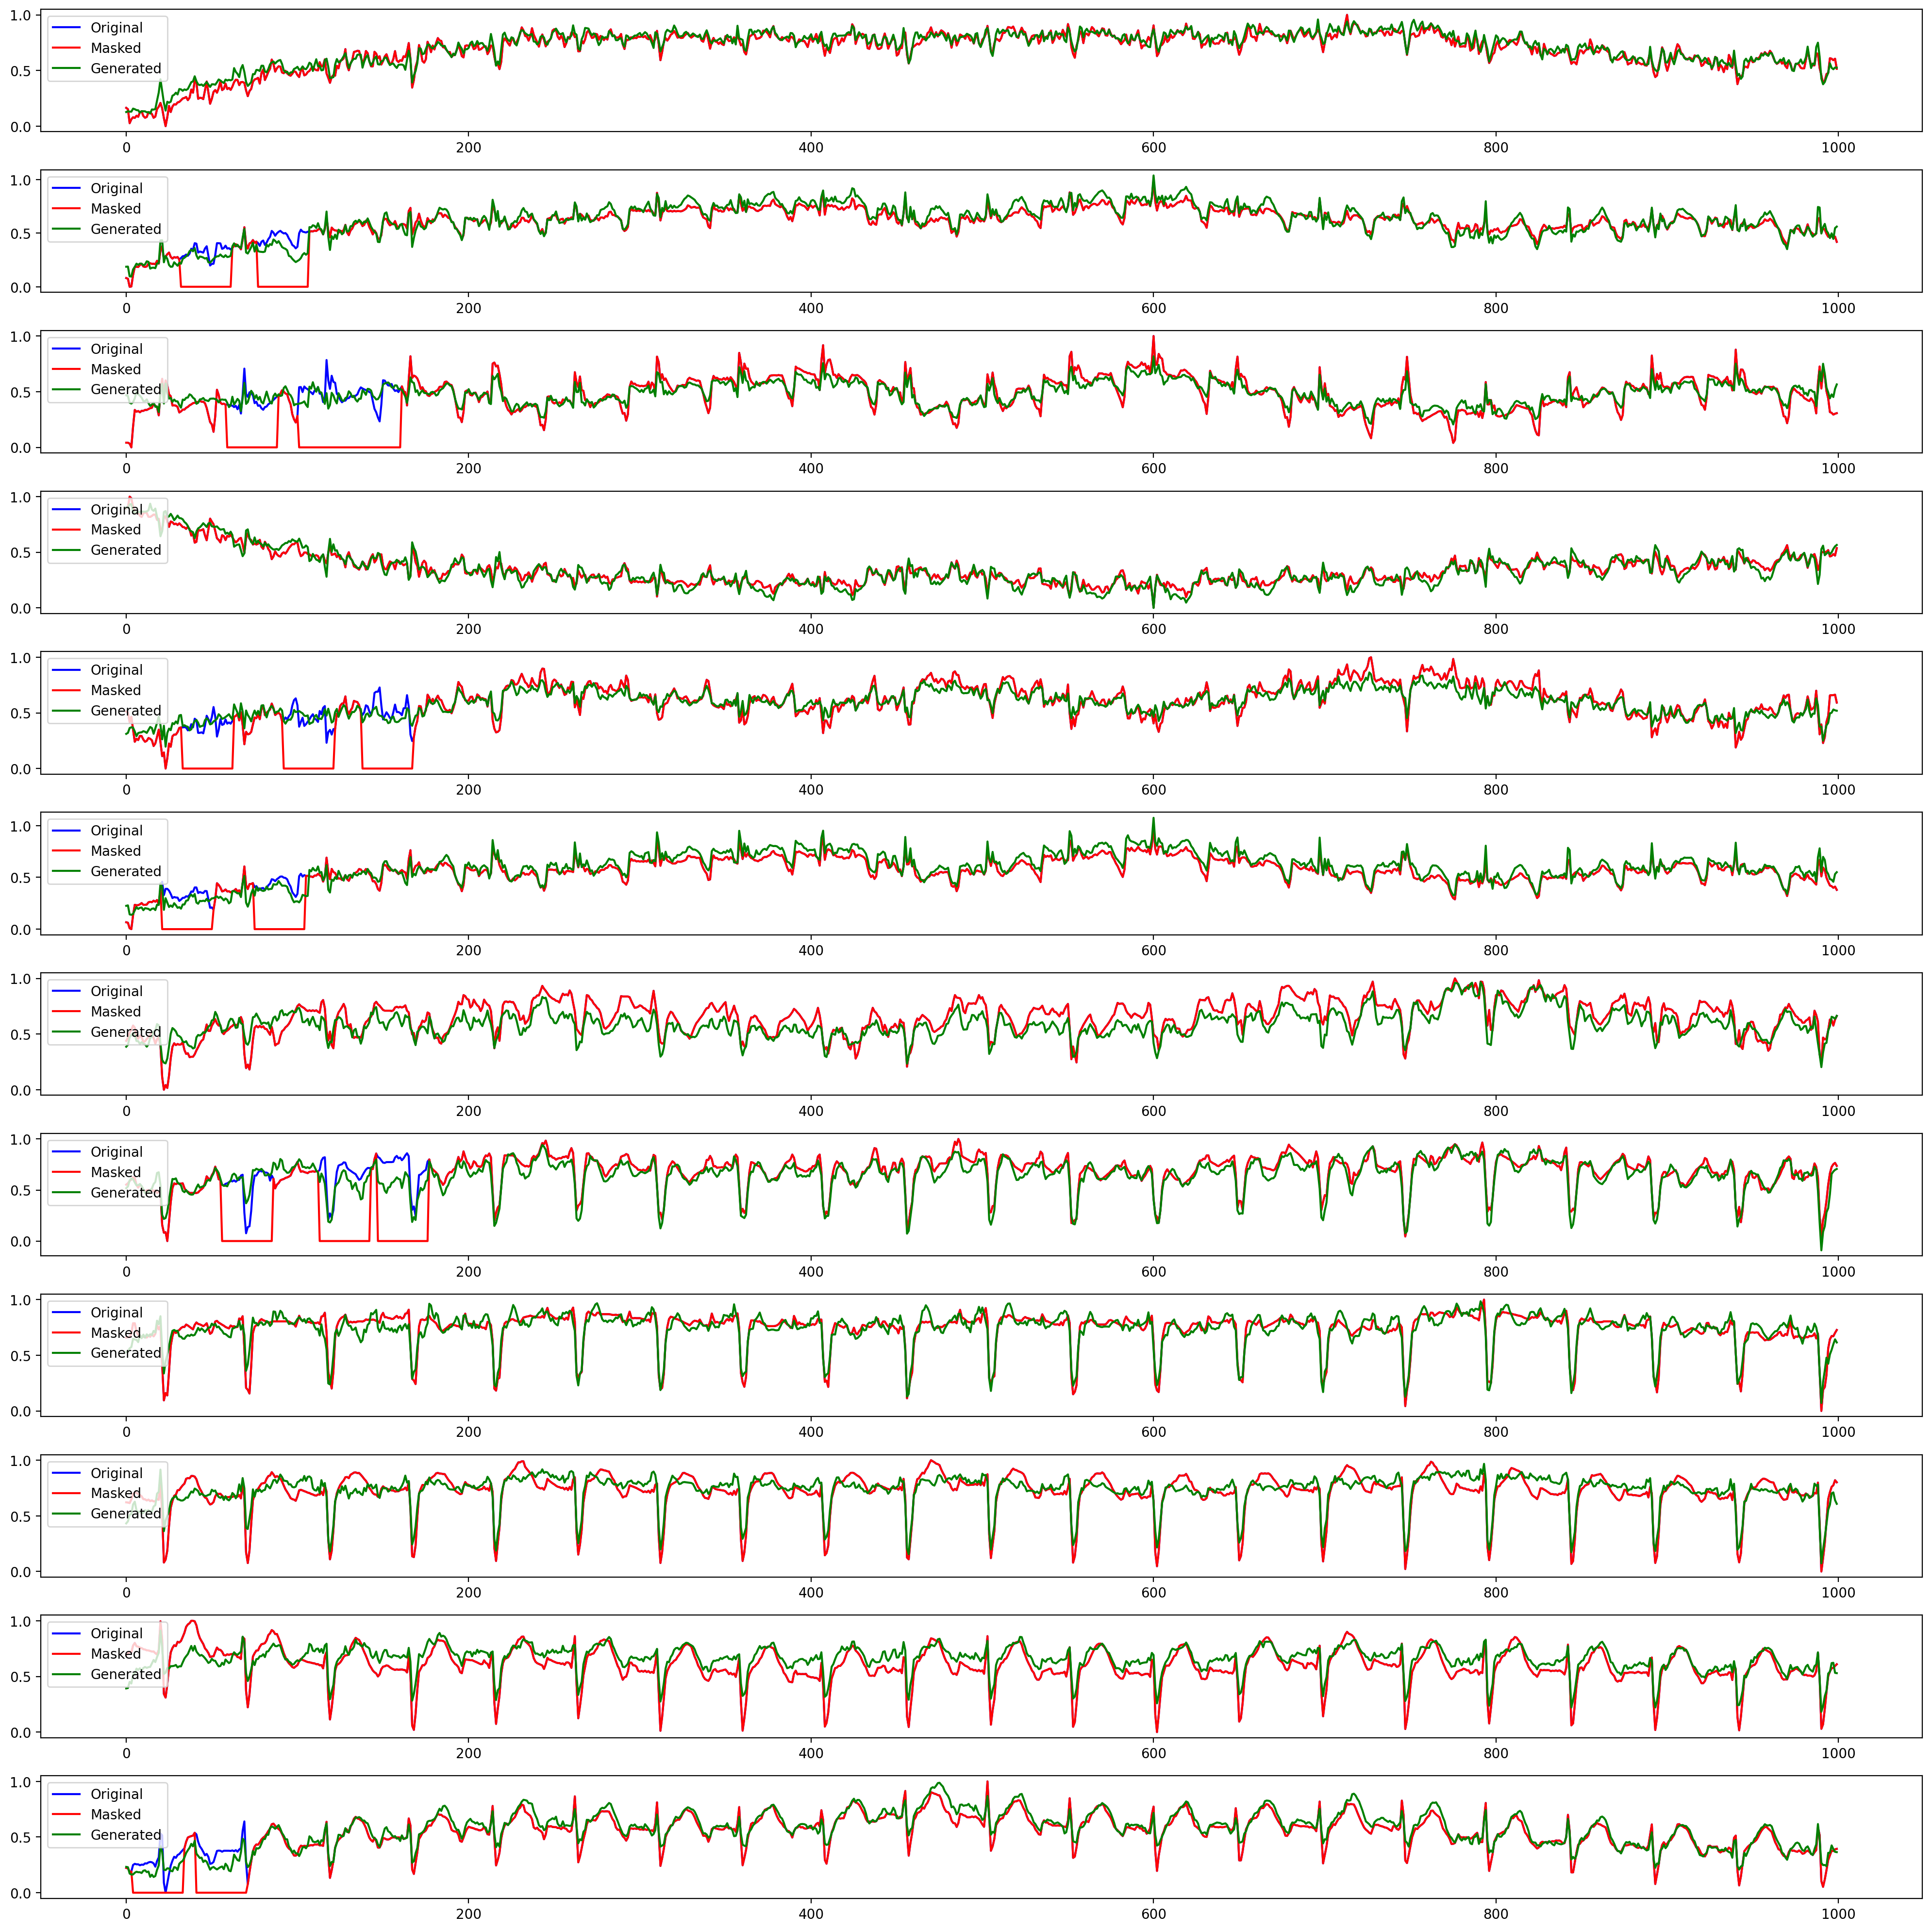

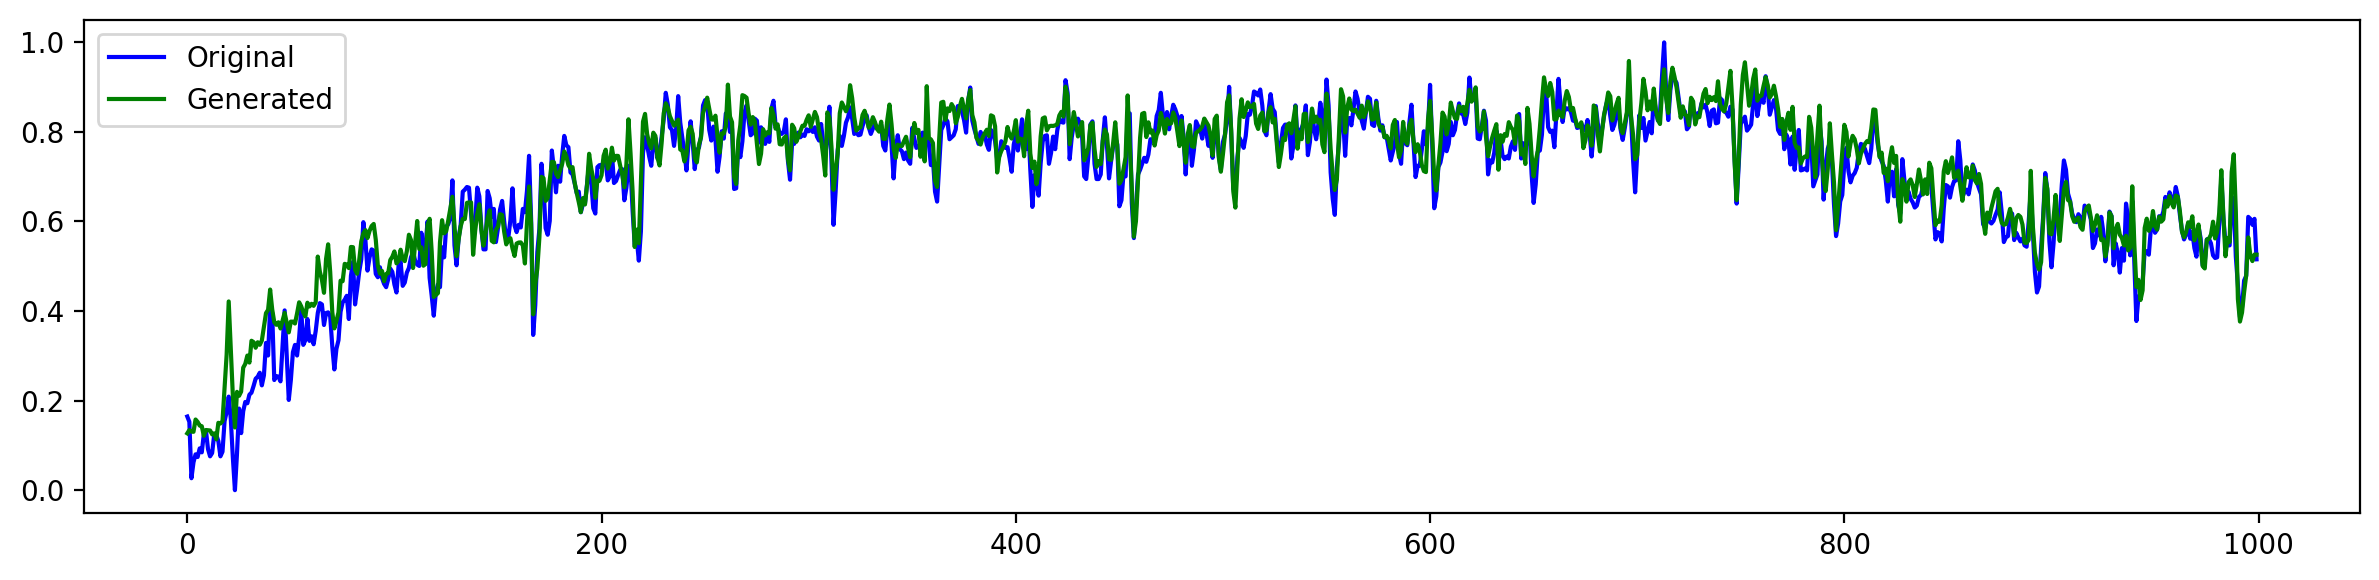

In [3]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch

from unet import UNet
from utils import load_npy, normalize_channel


def random_mask(data, mask_prob):  # 32, 128
    mask_prob_per_channel = np.random.rand(data.shape[0]) < mask_prob
    masked_data = data.copy()

    for channel in range(data.shape[0]):
        if mask_prob_per_channel[channel]:
            start_point = random.randint(0, data.shape[1] // 2)
            end_point = random.randint(start_point, data.shape[1] - start_point)
            masked_data[channel, start_point:end_point] = 0

    return masked_data


def plot(data, masked_data, outputs):
    plt.figure(figsize=(20, 20), dpi=200)
    for j in range(len(data)):
        plt.subplot(len(data), 1, j + 1)
        plt.plot(data[j], color='blue', label='Original')
        plt.plot(masked_data[j], color='red', label='Masked')
        plt.plot(outputs[j], color='green', label='Generated')
        # plt.axis('off')
        plt.legend(loc='upper left')
  
    plt.tight_layout()
    plt.show()


def plot_sing_lead(data, outputs):
    plt.figure(figsize=(12, 3), dpi=200)

    plt.plot(data[0], color='blue', label='Original')
    plt.plot(outputs[0], color='green', label='Generated')
    plt.legend(loc='upper left')
  
    plt.tight_layout()
    plt.show()



if __name__ == '__main__':
    device = 'cpu' if torch.cuda.is_available() else 'cpu'

    test_file = './mae_test/ALMI/6.npy'

    data, label = load_npy(test_file)
    data = normalize_channel(data)

    mask_prob = 0.5
    mask_length = 30
    channel_masks = int(len(data) * mask_prob)
    mask_channels = random.sample(range(len(data)), k=channel_masks)

    masked_data = data.copy()

    for mask_channel in mask_channels:
        num_masks = np.random.randint(2, 4)
        mask_starts = [np.random.randint(0, 60)]

        for _ in range(1, num_masks):
            mask_starts.append(
                np.random.randint(mask_starts[-1] + mask_length, mask_starts[-1] + mask_length * 2))

        for mask_start in mask_starts:
            masked_data[mask_channel][mask_start:mask_start + mask_length] = 0

    data_expand = data[np.newaxis, :]

    masked_data_expand = masked_data[np.newaxis, :]
    masked_data_torch = torch.from_numpy(masked_data_expand).float()

    model = UNet().to(device)
    model.load_state_dict(torch.load('./checkpoints/best_model.pt'))

    model.eval()
    with torch.no_grad():
        outputs = model(masked_data_torch)
        outputs = outputs.data.cpu().numpy()

    outputs = outputs.squeeze(0)

    plot(data, masked_data, outputs)
    plot_sing_lead(data, outputs)
